In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')

In [2]:
from hybridpy.learning import dynamicprogramming, ensemblepredictor
from hybridpy.dataset import triploader
import osmapping
import glob
import math
import numpy as np

In [3]:
dname = '/Users/astyler/projects/ChargeCarData/illah/'
trips = []
fnames = glob.glob(dname+'*.csv')
for fname in fnames:
    trips.append(triploader.load(fname))
    
len(trips)

/Users/astyler/anaconda/lib/python2.7/site-packages/hybridpy/dataset/triploader.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  trip.Acceleration[0] = 0


575

In [4]:
buffr = 0.01
mins=[(min(trip.Longitude) -buffr,min(trip.Latitude)-buffr) for trip in trips]
maxs=[(max(trip.Longitude) + buffr,max(trip.Latitude)+buffr) for trip in trips]

ll = map(min,zip(*mins))
ur = map(max,zip(*maxs))
print ll
print ur

[-80.274581999999995, 40.273409999999998]
[-79.510327000000004, 40.505786999999998]


In [5]:
ll = [-80.0, 40.40]
ur = [-79.87, 40.48]
mymap = osmapping.MLMap(ll,ur)

In [6]:
for trip in trips:
    trip['x'], trip['y'] = mymap.convert_coordinates(trip[['Longitude','Latitude']].values).T

In [7]:
mymap.load_shape_file('./shapefiles/pittsburgh/line.shp')
mymap.load_shape_file('./shapefiles/pittsburgh/polygon.shp')

In [8]:
mymap.clear_selected_shapes()

road = {'edgecolor':'white','lw':3, 'facecolor':'none','zorder':6};

mymap.select_shape('highway','motorway',**road)
mymap.select_shape('highway','trunk',**road)
mymap.select_shape('highway','primary',**road)
mymap.select_shape('highway','secondary',**road)
mymap.select_shape('highway','tertiary',**road)
mymap.select_shape('highway','residential',**road)
mymap.select_shape('leisure','park',facecolor='#BBDDBB',edgecolor='none',zorder=4)
mymap.select_shape('waterway','riverbank',facecolor='#CCCCEE', edgecolor='none', zorder=5)

mymap.select_shape('natural','water',facecolor='#CCCCEE', edgecolor='none', zorder=5)

In [9]:
training = trips[0:4]+trips[5:]
test = trips[4]

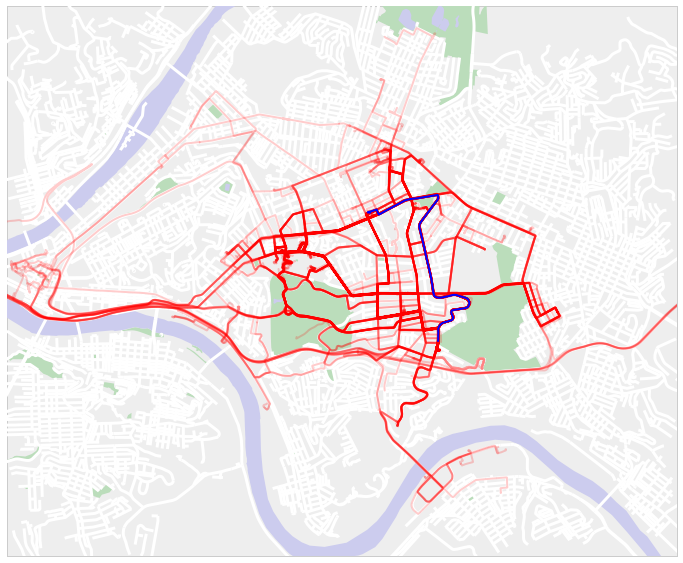

In [10]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
mymap.draw_map(ax, map_fill='#eeeeee')

for (idx,trip) in enumerate(training):
    ax.plot(trip.x, trip.y, lw=2, alpha=0.2, c='red', zorder=99)
    
ax.plot(test.x, test.y, lw=2, alpha=1, c='blue', zorder=100)

In [11]:
test.head()

,Latitude,Longitude,Elevation,Bearing,PlanarDistance,Speed,Acceleration,Power,TotalEnergyUsed,PeriodMS,Time,ElapsedSeconds,SpeedFilt,ElevationFilt,HeadingRaw,HeadingCosF,HeadingSinF,GradientRaw,x,y
0,40.450752,-79.929198,247.68,2.98,13.28,13.275,0.000000,3342.2758,0.0000,1000,1267506595000,0,13.275005,247.734948,2.981878,-0.984082,0.159214,0.000000,8315.788601,7858.642763
1,40.450771,-79.929353,247.68,2.96,10.00,10.001,-2.253629,-16710.7009,0.9284,1000,1267506596000,1,11.021376,247.758603,2.951334,-0.973176,0.198833,0.000000,8298.534080,7861.411421
2,40.450788,-79.929469,247.63,2.96,10.00,10.001,-1.846006,1862.2865,-3.7135,1000,1267506597000,2,9.175370,247.780730,2.962280,-0.962317,0.242518,-0.004547,8285.621019,7863.888641
3,40.450804,-79.929585,247.59,2.90,6.74,6.741,-2.632310,-11461.9095,-3.1961,1000,1267506598000,3,6.543060,247.801039,2.894059,-0.952754,0.290559,-0.003645,8272.707958,7866.220143
4,40.450819,-79.929663,247.51,2.70,2.74,2.745,-3.373287,-5999.9652,-6.3800,1000,1267506599000,4,3.169773,247.819220,2.716125,-0.947943,0.337331,-0.010247,8264.025038,7868.405927


In [105]:
features = ['Latitude', 'Longitude', 'HeadingCosF', 'HeadingSinF', 'SpeedFilt', 'Acceleration', 'Power', 'TotalEnergyUsed']
feature_weights =  [1,1,0.5,0.5,0.1,0,0,0.1]
ep = ensemblepredictor.EnsemblePredictor(training, features=features, feature_weights=feature_weights)

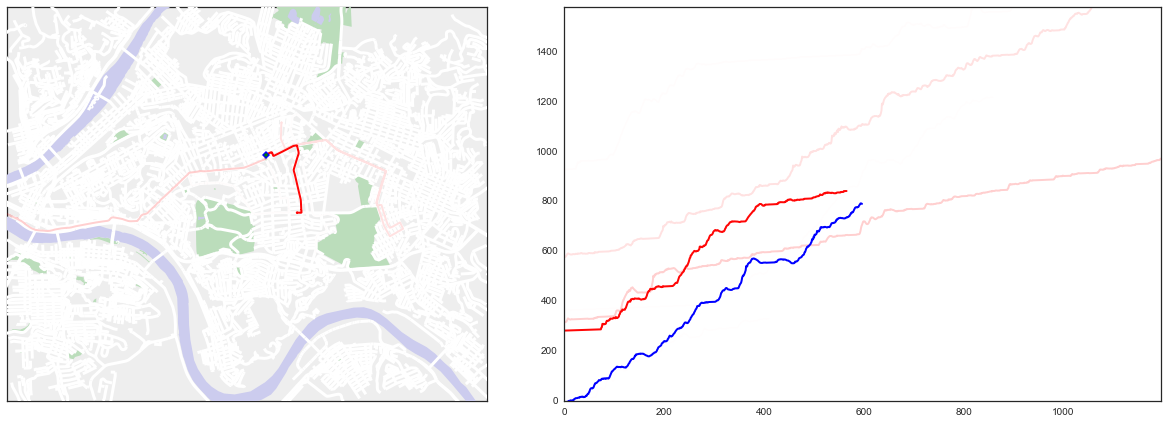

In [107]:
index = 5
results = ep.predict(test.iloc[index], 1e-2)
#best_weight = max(results)[0]
#results = [(w/best_weight, i) for (w,i) in results]
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(24,12))
gs = gridspec.GridSpec(1, 2, width_ratios=[10,7], height_ratios=[10,7])
gs.update(wspace=-0.15)
ax = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

mymap.draw_map(ax, map_fill='#eeeeee')

for (r, trip) in zip(results, training):
    idx = r[1]
    ax.plot(trip.x.iloc[idx:], trip.y.iloc[idx:], lw=2, alpha=r[0], c='red', zorder=99)
    ax.plot(trip.x.iloc[idx], trip.y.iloc[idx], 'gD', alpha=r[0], markersize=3, zorder=101)
    ax2.plot(trip.TotalEnergyUsed.iloc[idx:], lw=2, alpha=r[0], c='red')

ax.plot(test.x.iloc[index], test.y.iloc[index], 'bD', markersize=5, zorder=100)
gtEnergy = test.TotalEnergyUsed.iloc[index:]
ax2.plot(gtEnergy, lw=2, alpha=1, c='blue')
ax2.axis(xmin=0, xmax=2*len(gtEnergy), ymin=0, ymax=2*gtEnergy.values[-1])
ax2.set_ymargin(0.5)



In [66]:
gtEnergy.values[-1]

790.73659999999995

In [22]:
results[0:10]

[(0.0, 228),
 (0.048266210876858874, 0),
 (1.2227276682753845e-20, 1142),
 (0.0, 185),
 (0.0028553360073825113, 67),
 (0.0, 109),
 (7.7083373337263337e-82, 595),
 (3.6129761615395452e-22, 201),
 (7.4720882586675289e-28, 387),
 (8.1712797034348343e-213, 113)]

ERROR! Session/line number was not unique in database. History logging moved to new session 209


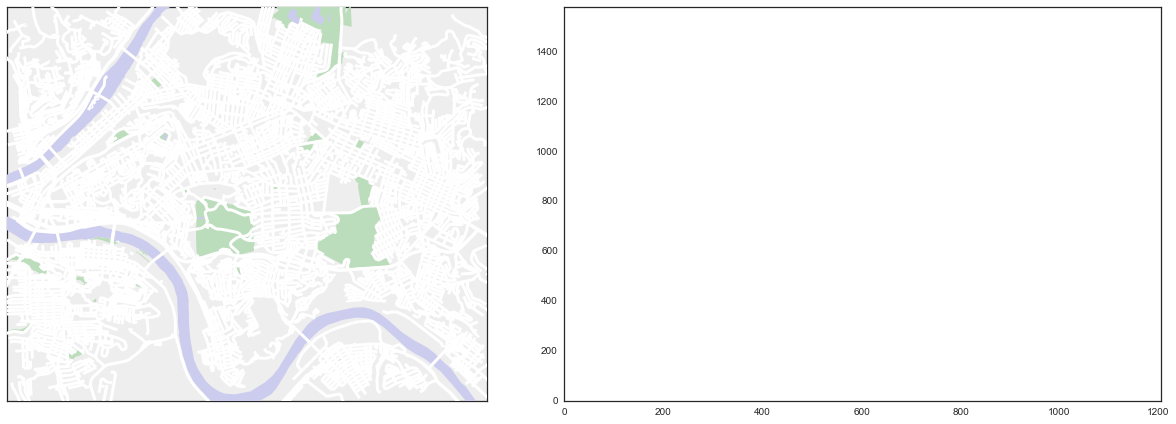

In [110]:
ep = ensemblepredictor.EnsemblePredictor(training, features=features, feature_weights=feature_weights)

fig = plt.figure(figsize=(24,12))
gs = gridspec.GridSpec(1, 2, width_ratios=[10,7], height_ratios=[10,7])
gs.update(wspace=-0.15)
ax = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

ax2.set_xlim(0, 2*len(test.TotalEnergyUsed))
ax2.set_ylim(0, 2*test.TotalEnergyUsed.values[-1])

mymap.draw_map(ax, map_fill='#eeeeee')
weights = []  
for index in range(5,len(test),5):
    results = ep.predict(test.iloc[index], sigma=1e-2)
    #results = [(norm(r[0], 1e-4), r[1]) for r in ep.predict(test.iloc[index])]
    #results = [(1.0/r[0], r[1]) for r in ep.predict(test.iloc[index])]
    #best_match = max(results)
    #results = [(w/best_match[0], i) for (w,i) in results]

    lines = []
    for (r, trip) in zip(results, training):
        idx = r[1]
        lines.append(ax.plot(trip.x.iloc[idx:], trip.y.iloc[idx:], lw=2, alpha=r[0], c='red', zorder=99)[0])
        energy = trip.TotalEnergyUsed.iloc[idx:]
        energy = energy - energy.values[0]
        lines.append(ax2.plot(energy, lw=2, alpha=r[0], c='red')[0])
        
    pt = ax.plot(test.x.iloc[index], test.y.iloc[index], 'bD', markersize=5, zorder=101)[0]
    
    gtEnergy = test.TotalEnergyUsed.iloc[index:]
    gtEnergy = gtEnergy - gtEnergy.values[0]
    line = ax2.plot(gtEnergy, lw=2, alpha=1, c='blue')
    lines.append(line[0])

    plt.savefig('video/frame'+format(index/5, '03')+'.png')
    
    
    for line in lines:
        line.remove()
        del line
    pt.remove()